In [1]:
from PIL import Image
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np
import torchvision
from torchvision import transforms
from glob import glob
import cv2
import random

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,plot_confusion_matrix

import time
import copy

In [2]:
def seed(seed = 42):
    random.seed(seed) # python random seed 고정
    os.environ['PYTHONHASHSEED'] = str(seed) # os 자체의 seed 고정
    np.random.seed(seed) # numpy seed 고정 
    torch.manual_seed(seed) # torch seed 고정
    torch.cuda.manual_seed(seed) # cudnn seed 고정
    torch.backends.cudnn.deterministic = True # cudnn seed 고정(nn.Conv2d)
    torch.backends.cudnn.benchmark = False # CUDA 내부 연산에서 가장 빠른 알고리즘을 찾아 수행

## DataLoader worker에 대한 seed 설정
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)
    
seed()

In [3]:
test_normal_path ='/mnt/nas100_vol2/LeeJungHoon/Aov_task_curation_data/curation_data_v3/data_v3/normal_test_v3/*.jpg'
test_abnormal_path ='/mnt/nas100_vol2/LeeJungHoon/Aov_task_curation_data/curation_data_v3/data_v3/abnormal_test_v3/*.jpg'

In [6]:
test_normal_path_ex ='/mnt/nas100_vol2/LeeJungHoon/Aov_task_curation_data/curation_data_v4/data_v4_7_1/normal_test_v4/*.jpg'
test_abnormal_path_ex ='/mnt/nas100_vol2/LeeJungHoon/Aov_task_curation_data/curation_data_v4/data_v4_7_1/abnormal_test_v4/*.jpg'

In [5]:
test_normal_path_7 ='/mnt/nas100_vol2/LeeJungHoon/Aov_task_curation_data/curation_data_v3/data_v3(7_1.5_1.5)/normal_test_v3/*.jpg'
test_abnormal_path_7 ='/mnt/nas100_vol2/LeeJungHoon/Aov_task_curation_data/curation_data_v3/data_v3(7_1.5_1.5)/abnormal_test_v3/*.jpg' 

In [8]:
test_normal_glob = glob(test_normal_path)
test_abnormal_glob = glob(test_abnormal_path)

test_normal_ex_glob = glob(test_normal_path_ex)
test_abnormal_ex_glob = glob(test_abnormal_path_ex)

test_normal_7_glob = glob(test_normal_path_7)
test_abnormal_7_glob = glob(test_abnormal_path_7)

print('test_normal :', len(test_normal_glob))
print('test_abnormal :', len(test_abnormal_glob))
print('------------------------------------')
print('test_normal :', len(test_normal_ex_glob))
print('test_abnormal :', len(test_abnormal_ex_glob))
print('------------------------------------')
print('test_normal :', len(test_normal_7_glob))
print('test_abnormal :', len(test_abnormal_7_glob))


test_normal : 66
test_abnormal : 39
------------------------------------
test_normal : 76
test_abnormal : 78
------------------------------------
test_normal : 92
test_abnormal : 46


- 총 실험이 내부 데이터만 이용한 실험 1과 외부 데이터를 포함해서 진행한 실험2가 있기 때문에 각각 dataloader 생성후 한 그래프로 출력해서 비교

In [9]:
#내부 데이터만 이용한 실험 dataset
class Aov_Dysplasia_dataset(Dataset):
    def __init__(self, normal_path, abnormal_path, transform=None):
        #생성자, 데이터를 전처리 
        self.normal_path_list = glob(normal_path)
        self.abnormal_path_list = glob(abnormal_path)
        print(len(self.normal_path_list))
#         self.mode = mode 
    
#         label = np.array([[0, 1], [1, 0]], dtype=np.float32)
        
#         self.label_list = []
#         for i in self.normal_path_list:
#             self.label_list.append(label[0])
            
#         for i in self.abnormal_path_list:
#             self.label_list.append(label[1])
            
        label_policy = {
            'normal': 0, 
            'abnormal': 1
        }
    
        self.label_list= []
        
        for i in self.normal_path_list:
            self.label_list.append(label_policy["normal"])
            
        for i in self.abnormal_path_list:
            self.label_list.append(label_policy["abnormal"])
        
        self.total_img_path_list = self.normal_path_list + self.abnormal_path_list
        self.transform = transform
    
    def __len__(self):
        return len(self.total_img_path_list)
    
    def __getitem__(self, idx):
        
        img = cv2.imread(self.total_img_path_list[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = np.array(img, dtype=np.float32)
        #들어오는 이미지의 컬러 형태가 BGR인지 RGB인지 모르기때문에 변형

        
        label = self.label_list[idx]
        
        if self.transform is not None:
            transformed = self.transform(image=img)
            img = transformed['image'] 
            img = torch.tensor(np.array(img), dtype=torch.float32)
            # img = torch.FloatTensor(img)
            img = (img - torch.min(img)) / (torch.max(img)-torch.min(img))
            
            return {'img': img, 'label': label, 'filename': self.total_img_path_list[idx]}
        
        else:
            # img = transformed['image']
            img = torch.tensor(np.array(img), dtype=torch.float32)
            # img = torch.FloatTensor(img)
            img = (img - torch.min(img)) / (torch.max(img)-torch.min(img))
            return{'img': img, 'label': label}

In [10]:
import albumentations as A 
from  albumentations.pytorch import ToTensorV2

test_transform = A.Compose(
    [
        A.Resize(224,224, interpolation = cv2.INTER_AREA),
        ToTensorV2()
    ])

In [11]:
test_dataset = Aov_Dysplasia_dataset(test_normal_path, test_abnormal_path, transform = test_transform)
test_dataset_ex = Aov_Dysplasia_dataset(test_normal_path_ex, test_abnormal_path_ex, transform = test_transform)
test_dataset_7 = Aov_Dysplasia_dataset(test_normal_path_7, test_abnormal_path_7, transform = test_transform)

66
76
92


In [12]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle = False ,worker_init_fn=seed_worker)
test_dataloader_ex = torch.utils.data.DataLoader(test_dataset_ex, batch_size=1, shuffle = False ,worker_init_fn=seed_worker)
test_dataloader_7 = torch.utils.data.DataLoader(test_dataset_7, batch_size=1, shuffle = False ,worker_init_fn=seed_worker)

In [13]:
print('test_dataset :',len(test_dataset))
print('test2_ex_dataset :',len(test_dataset_ex))
print('test2_7_dataset :',len(test_dataset_7))

test_dataset : 105
test2_ex_dataset : 154
test2_7_dataset : 138


In [ ]:
from torchvision import models
import torch

resnet50_pretrained = models.resnet50(pretrained=True)
print(resnet50_pretrained)

In [ ]:
num_classes = 1
num_features = resnet50_pretrained.fc.in_features
resnet50_pretrained.fc = nn.Linear(num_features, num_classes)

resnet50_pretrained

In [ ]:
from torchvision import models
import torch
import timm
# m = timm.create_model('seresnet50', pretrained=True)

seresnet50_pretrained = timm.create_model('seresnet50', pretrained=True)
print(seresnet50_pretrained)

In [ ]:
num_classes = 1
num_features = seresnet50_pretrained.fc.in_features
seresnet50_pretrained.fc = nn.Linear(num_features, num_classes)

seresnet50_pretrained

In [18]:
GPU_NUM = 0
os.environ["CUDA_VISIBLE_DEVICES"]='1'
print('gpu? ', torch.cuda.is_available())
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print('Current gpu: ', torch.cuda.current_device())

if device.type == 'cuda':
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')
    
# model = resnet50_pretrained.to(device)
# x = torch.randn(3, 3, 224, 224).to(device)
# output = model(x)
# print(output)

gpu?  True
Current gpu:  0
Allocated: 0.0 GB
Cached:    0.0 GB


/home/crop2292/anaconda3/envs/hoon/lib/python3.6/site-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [34]:
# model_name = 'Resnet50(b=16,Adam,seed)_weights_pt'
# model_name1 = 'Resnet50(b=16,Adam,Focal_alpha(0.75),WRS,sche,seed)_weights_pt'
# model_name2 = 'Resnet50(b=16,Adam,Focal_alpha(0.75),WRS,seed)_weights_pt'
# model_name3 = 'seresnet50(b=16,Adam,Focal_alpha(0.75),WRS,sche,seed)_weights_pt'
# model_name4 = 'seresnet50(b=16,Adam,Focal_alpha(0.75),WRS,sche,seed,7)_weights_pt'
model_ex_name = 'resnet50(b=16,Adam,Focal_alpha(0.65),WRS,sche,seed,7,pre,AUG,re)_weights_pt'

model_path = '/mnt/nas100_vol2/LeeJungHoon/AOV_task(binary_clssification)/Model_V2/weights_file/'

In [35]:
# model = resnet50_pretrained.to(device)
# model.load_state_dict(torch.load(model_path + model_name))

# model1 = resnet50_pretrained.to(device)
# model1.load_state_dict(torch.load(model_path + model_name1))

# model2 = resnet50_pretrained.to(device)
# model2.load_state_dict(torch.load(model_path + model_name2))

model_ex = resnet50_pretrained.to(device)
model_ex.load_state_dict(torch.load(model_path + model_ex_name))

<All keys matched successfully>

In [32]:
# model3 = seresnet50_pretrained.to(device)
# model3.load_state_dict(torch.load(model_path + model_name3))

# model4 = seresnet50_pretrained.to(device)
# model4.load_state_dict(torch.load(model_path + model_name4))

<All keys matched successfully>

## Base Line model test

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# output = model(input_data)
model.eval()  

test_accuracy = 0.0
running_accuracy = 0.0
len_dataset = len(test_dataloader.dataset)
pred = []
label = []
outputs = []
incorrect_normal_list = []
incorrect_abnormal_list = []

# valid data
with torch.no_grad():
    for data in test_dataloader:
        
        inputs = data['img']
        labels = data['label']
        idx = data['filename']
        
        inputs = inputs.to(device)
        labels = labels.to(device, dtype = torch.float32)
        print(model(inputs))
        
        output = torch.squeeze(model(inputs))
        output_sig = torch.sigmoid(output)
        outputs.append(output_sig.cpu())
        y_pred = output_sig.cpu()
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        
        if y_pred != labels.cpu():
            if labels.cpu() == 1:
                incorrect_abnormal_list.append(idx)
            else:
                incorrect_normal_list.append(idx)
                
            
        
        
        y_pred_ = y_pred.detach().cpu().numpy().tolist()
        print(y_pred_)
        
        correct_num = y_pred.eq(labels.cpu()).int().sum()
        running_accuracy += correct_num
        print(correct_num)
        
        labels_numpy = labels.detach().cpu().numpy().tolist()
        print(labels_numpy)
        
        
        pred.append(y_pred_)
        label.append(labels_numpy)
        
#         print(confusion_matrix(y_pred,labels_numpy))
#         print(classification_report(y_pred,labels_numpy))
#         print(accuracy_score(y_pred,labels_numpy))

test_accuracy = running_accuracy / len_dataset


## Resnet50(b=16,Adam,Focal_alpha(0.75),WRS,sche,seed) test

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# output = model(input_data)
model1.eval()  

test_accuracy = 0.0
running_accuracy = 0.0
len_dataset = len(test_dataloader.dataset)
pred_1 = []
label_1 = []
outputs_1 = []
incorrect_normal_list = []
incorrect_abnormal_list = []

# valid data
with torch.no_grad():
    for data in test_dataloader:
        
        inputs = data['img']
        labels = data['label']
        idx = data['filename']
        
        inputs = inputs.to(device)
        labels = labels.to(device, dtype = torch.float32)
        print(model1(inputs))
        
        output = torch.squeeze(model1(inputs))
        output_sig = torch.sigmoid(output)
        outputs_1.append(output_sig.cpu())
        y_pred = output_sig.cpu()
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        
        if y_pred != labels.cpu():
            if labels.cpu() == 1:
                incorrect_abnormal_list.append(idx)
            else:
                incorrect_normal_list.append(idx)
                
            
        
        
        y_pred_ = y_pred.detach().cpu().numpy().tolist()
        print(y_pred_)
        
        correct_num = y_pred.eq(labels.cpu()).int().sum()
        running_accuracy += correct_num
        print(correct_num)
        
        labels_numpy = labels.detach().cpu().numpy().tolist()
        print(labels_numpy)
        
        
        pred_1.append(y_pred_)
        label_1.append(labels_numpy)
        
#         print(confusion_matrix(y_pred,labels_numpy))
#         print(classification_report(y_pred,labels_numpy))
#         print(accuracy_score(y_pred,labels_numpy))

test_accuracy = running_accuracy / len_dataset


## Resnet50(b=16,Adam,Focal_alpha(0.75),WRS,seed)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# output = model(input_data)
model2.eval()  

test_accuracy = 0.0
running_accuracy = 0.0
len_dataset = len(test_dataloader.dataset)
pred_2 = []
label_2 = []
outputs_2 = []
incorrect_normal_list = []
incorrect_abnormal_list = []

# valid data
with torch.no_grad():
    for data in test_dataloader:
        
        inputs = data['img']
        labels = data['label']
        idx = data['filename']
        
        inputs = inputs.to(device)
        labels = labels.to(device, dtype = torch.float32)
        print(model2(inputs))
        
        output = torch.squeeze(model2(inputs))
        output_sig = torch.sigmoid(output)
        outputs_2.append(output_sig.cpu())
        y_pred = output_sig.cpu()
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        
        if y_pred != labels.cpu():
            if labels.cpu() == 1:
                incorrect_abnormal_list.append(idx)
            else:
                incorrect_normal_list.append(idx)
                
            
        
        
        y_pred_ = y_pred.detach().cpu().numpy().tolist()
        print(y_pred_)
        
        correct_num = y_pred.eq(labels.cpu()).int().sum()
        running_accuracy += correct_num
        print(correct_num)
        
        labels_numpy = labels.detach().cpu().numpy().tolist()
        print(labels_numpy)
        
        
        pred_2.append(y_pred_)
        label_2.append(labels_numpy)
        
#         print(confusion_matrix(y_pred,labels_numpy))
#         print(classification_report(y_pred,labels_numpy))
#         print(accuracy_score(y_pred,labels_numpy))

test_accuracy = running_accuracy / len_dataset


## seresnet50(b=16,Adam,Focal_alpha(0.75),WRS,sche,seed)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# output = model(input_data)
model3.eval()  

test_accuracy = 0.0
running_accuracy = 0.0
len_dataset = len(test_dataloader.dataset)
pred_3 = []
label_3 = []
outputs_3 = []
incorrect_normal_list = []
incorrect_abnormal_list = []

# valid data
with torch.no_grad():
    for data in test_dataloader:
        
        inputs = data['img']
        labels = data['label']
        idx = data['filename']
        
        inputs = inputs.to(device)
        labels = labels.to(device, dtype = torch.float32)
        print(model3(inputs))
        
        output = torch.squeeze(model3(inputs))
        output_sig = torch.sigmoid(output)
        outputs_3.append(output_sig.cpu())
        y_pred = output_sig.cpu()
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        
        if y_pred != labels.cpu():
            if labels.cpu() == 1:
                incorrect_abnormal_list.append(idx)
            else:
                incorrect_normal_list.append(idx)
                
            
        
        
        y_pred_ = y_pred.detach().cpu().numpy().tolist()
        print(y_pred_)
        
        correct_num = y_pred.eq(labels.cpu()).int().sum()
        running_accuracy += correct_num
        print(correct_num)
        
        labels_numpy = labels.detach().cpu().numpy().tolist()
        print(labels_numpy)
        
        
        pred_3.append(y_pred_)
        label_3.append(labels_numpy)
        
#         print(confusion_matrix(y_pred,labels_numpy))
#         print(classification_report(y_pred,labels_numpy))
#         print(accuracy_score(y_pred,labels_numpy))

test_accuracy = running_accuracy / len_dataset


## seresnet50(b=16,Adam,Focal_alpha(0.75),WRS,sche,seed,7)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# output = model(input_data)
model4.eval()  

test_accuracy = 0.0
running_accuracy = 0.0
len_dataset = len(test_dataloader_7.dataset)
pred_4 = []
label_4 = []
outputs_4 = []
incorrect_normal_list = []
incorrect_abnormal_list = []

# valid data
with torch.no_grad():
    for data in test_dataloader_7:
        
        inputs = data['img']
        labels = data['label']
        idx = data['filename']
        
        inputs = inputs.to(device)
        labels = labels.to(device, dtype = torch.float32)
        print(model3(inputs))
        
        output = torch.squeeze(model4(inputs))
        output_sig = torch.sigmoid(output)
        outputs_4.append(output_sig.cpu())
        y_pred = output_sig.cpu()
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        
        if y_pred != labels.cpu():
            if labels.cpu() == 1:
                incorrect_abnormal_list.append(idx)
            else:
                incorrect_normal_list.append(idx)
                
            
        
        
        y_pred_ = y_pred.detach().cpu().numpy().tolist()
        print(y_pred_)
        
        correct_num = y_pred.eq(labels.cpu()).int().sum()
        running_accuracy += correct_num
        print(correct_num)
        
        labels_numpy = labels.detach().cpu().numpy().tolist()
        print(labels_numpy)
        
        
        pred_4.append(y_pred_)
        label_4.append(labels_numpy)
        
#         print(confusion_matrix(y_pred,labels_numpy))
#         print(classification_report(y_pred,labels_numpy))
#         print(accuracy_score(y_pred,labels_numpy))

test_accuracy = running_accuracy / len_dataset


## resnet50(b=16,Adam,Focal_alpha(0.65),WRS,sche,seed,7,pre,AUG)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# output = model(input_data)
model_ex.eval()  

test_accuracy = 0.0
running_accuracy = 0.0
len_dataset = len(test_dataloader_ex.dataset)
pred_ex = []
label_ex = []
outputs_ex = []
incorrect_normal_list = []
incorrect_abnormal_list = []

# valid data
with torch.no_grad():
    for data in test_dataloader_ex:
        
        inputs = data['img']
        labels = data['label']
        idx = data['filename']
        
        inputs = inputs.to(device)
        labels = labels.to(device, dtype = torch.float32)
        print(model_ex(inputs))
        
        output = torch.squeeze(model_ex(inputs))
        output_sig = torch.sigmoid(output)
        outputs_ex.append(output_sig.cpu())
        y_pred = output_sig.cpu()
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        
        if y_pred != labels.cpu():
            if labels.cpu() == 1:
                incorrect_abnormal_list.append(idx)
            else:
                incorrect_normal_list.append(idx)
                
            
        
        
        y_pred_ = y_pred.detach().cpu().numpy().tolist()
        print(y_pred_)
        
        correct_num = y_pred.eq(labels.cpu()).int().sum()
        running_accuracy += correct_num
        print(correct_num)
        
        labels_numpy = labels.detach().cpu().numpy().tolist()
        print(labels_numpy)
        
        
        pred_ex.append(y_pred_)
        label_ex.append(labels_numpy)
        
#         print(confusion_matrix(y_pred,labels_numpy))
#         print(classification_report(y_pred,labels_numpy))
#         print(accuracy_score(y_pred,labels_numpy))

test_accuracy = running_accuracy / len_dataset


- confusion Matrix & ROC Curve

In [37]:
from sklearn.metrics import roc_curve
from numpy import argmax

# calculate roc curves
fpr, tpr, thresholds = roc_curve(label, outputs)
fpr1, tpr1, thresholds_1 = roc_curve(label_1, outputs_1)
fpr2, tpr2, thresholds_2 = roc_curve(label_2, outputs_2)
fpr3, tpr3, thresholds_3 = roc_curve(label_3, outputs_3)
fpr4, tpr4, thresholds_4 = roc_curve(label_4, outputs_4)
fpr_ex, tpr_ex, thresvholds_ex = roc_curve(label_ex, outputs_ex)

#get the best threshold
J = tpr - fpr
J1 = tpr1 - fpr1
J2 = tpr2 - fpr2
J3 = tpr3 - fpr3
J4 = tpr4 - fpr4
J_ex = tpr_ex - fpr_ex

ix = argmax(J)
ix1 = argmax(J1)
ix2 = argmax(J2)
ix3 = argmax(J3)
ix4 = argmax(J4)
ix_ex = argmax(J_ex)

best_thresh = thresholds[ix]
best_thresh1 = thresholds_1[ix1]
best_thresh2 = thresholds_2[ix2]
best_thresh3 = thresholds_3[ix3]
best_thresh4 = thresholds_4[ix4]
best_thresh_ex = thresholds_3[ix_ex]

print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh1, tpr1[ix1], 1-fpr1[ix1], J1[ix1]))
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh2, tpr2[ix2], 1-fpr2[ix2], J2[ix2]))
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh3, tpr3[ix3], 1-fpr3[ix3], J3[ix3]))
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh4, tpr4[ix4], 1-fpr4[ix4], J4[ix4]))
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh_ex, tpr_ex[ix_ex], 1-fpr_ex[ix_ex], J_ex[ix_ex]))



print(confusion_matrix(label,pred))
print(confusion_matrix(label_1,pred_1))
print(confusion_matrix(label_2,pred_2))
print(confusion_matrix(label_3,pred_3))
print(confusion_matrix(label_4,pred_4))
print(confusion_matrix(label_ex,pred_ex))
# print(classification_report(label,pred))
# cm = confusion_matrix(label,pred)

Best Threshold=0.238699, sensitivity = 0.667, specificity = 0.833, J=0.500
Best Threshold=0.267937, sensitivity = 0.923, specificity = 0.758, J=0.681
Best Threshold=0.464133, sensitivity = 0.821, specificity = 0.818, J=0.639
Best Threshold=0.528726, sensitivity = 0.846, specificity = 0.864, J=0.710
Best Threshold=0.374231, sensitivity = 0.935, specificity = 0.804, J=0.739
Best Threshold=0.589771, sensitivity = 0.910, specificity = 0.908, J=0.818
[[62  4]
 [20 19]]
[[55 11]
 [ 8 31]]
[[56 10]
 [ 9 30]]
[[54 12]
 [ 6 33]]
[[77 15]
 [ 8 38]]
[[67  9]
 [ 7 71]]


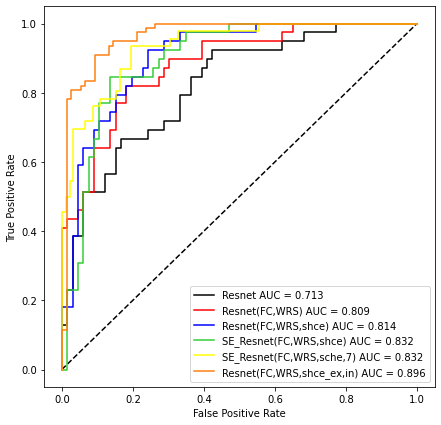

In [38]:
from sklearn.metrics import roc_auc_score

#plot roc and best threshold
sens, spec = tpr[ix], 1-fpr[ix]
sens1, spec1 = tpr1[ix1], 1-fpr1[ix1]
sens2, spec2 = tpr2[ix2], 1-fpr2[ix2]
sens3, spec3 = tpr3[ix3], 1-fpr3[ix3]
sens4, spec4 = tpr4[ix4], 1-fpr4[ix4]
sens_ex, spec_ex = tpr[ix_ex], 1-fpr[ix_ex]

# plot the roc curve for the model
plt.figure(figsize=(7,7))
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05, label="Resnet AUC = %.3f" % roc_auc_score(label, pred))
plt.plot(fpr2, tpr2, marker='.', color='red', markersize=0.05, label="Resnet(FC,WRS) AUC = %.3f" % roc_auc_score(label_2, pred_2))
plt.plot(fpr1, tpr1, marker='.', color='blue', markersize=0.05, label="Resnet(FC,WRS,shce) AUC = %.3f" % roc_auc_score(label_1, pred_1))
plt.plot(fpr3, tpr3, marker='.', color='limegreen', markersize=0.05, label="SE_Resnet(FC,WRS,shce) AUC = %.3f" % roc_auc_score(label_3, pred_3))
plt.plot(fpr4, tpr4, marker='.', color='yellow', markersize=0.05, label="SE_Resnet(FC,WRS,sche,7) AUC = %.3f" % roc_auc_score(label_4, pred_4))
plt.plot(fpr_ex, tpr_ex, marker='.', color='#ff7f0e', markersize=0.05, label="Resnet(FC,WRS,shce_ex,in) AUC = %.3f" % roc_auc_score(label_ex, pred_ex))
# plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='r', 
#             label='Best threshold = %.3f, \nSensitivity = %.3f, \nSpecificity = %.3f' % (best_thresh, sens, spec))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()